In [1]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed
import scipy as sci
from qutip import *
from cosmatrix import cosm,expm_pade

In [2]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k

In [3]:
sdim = dims = 8
phi_ex = flux =  0.435
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2

    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)
    g4 = Ej*phi_zpf**4*c4/4/3/2
    c5 = (1-N**4)/N**4 * np.sin(phi_min/N)
    g5 = Ej * phi_zpf**5 * c5 / 5/4/3/2/1
    s = annihilation(sdim)
    sd = creation(sdim)
    x3 = (s+sd)@(s+sd)@(s+sd)
    x4 = (s+sd)@(s+sd)@(s+sd)@(s+sd)
    x5 = (s+sd)@x4
    Hs = omega_s * np.matmul(sd,s) + g3*x3 + g4*x4 + g5*x5
    Hs = Hs-Hs[0,0]*np.identity(len(Hs))
    x2 = np.matmul(s+sd,s+sd)
#     Hs = (omega_s * np.matmul(sd,s)
#         - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
#         + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
#     Hs = Hs-Hs[0,0]*np.identity(len(Hs))
    return Hs,-1j*(s-sd),phi_zpf

In [4]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega):
    N = 3   # number of large JJs in a SNAIL
    EJ = 70 * 2*np.pi   # junction energy of larger JJ 
    EC = 177e-3 * 2*np.pi   # charging energy of the SNAIL 
    beta = 0.12   # ratio between small and large JJ # external flux in SNAIL, e.g., 2pi = 1 flux quantum 
    Hs,charge_op,phi_zpf = SNAIL_H(phi_ex,beta,N,EJ,EC)
    #cavity1 parameters
    omega_c1 = 3*2*np.pi
    g_int1 =0.1043980977363549 * 2*np.pi 
    dimc1 = 4
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    #cavity1 parameters
    omega_c2 = 7*2*np.pi
    g_int2 =0.1043980977363549 * 2*np.pi 
    dimc2 = 4
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()

    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(sdim)

    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2)

    H0 = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc = np.kron(np.kron(charge_op,Ic1),Ic2)
    energy = np.diag(H0)
#     energy,U = np.linalg.eigh(H0)
#     U_dag = np.transpose(U.conjugate())
#     Hc = U_dag @ Hc @ U
#     H0 = U_dag @ H0 @ U
#     H0 = H0 - H0[0][0]*np.identity(len(H0))
    index1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    index2 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    bare_diff = (energy[index1] - energy[index2])/2/np.pi

    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, index1), basis(total_dim, index2)]


    max_overlap_indices = [0,0]
    max_overlaps = [0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    omegac1p = f_energies[max_overlap_indices[0]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, omegac1p , omega/2/np.pi)
    omegac1p = omegac1p + k *omega/2/np.pi
    omegac2p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, omegac2p, omega/2/np.pi)
    omegac2p = omegac2p + k *omega/2/np.pi
    diff = omegac2p - omegac1p
    return diff

In [5]:
detuning = energy_diff(0,10)

In [6]:
detuning

4.0114802366999

In [7]:
import scipy
def fit_avoided_crossing(energy_diff):

    # define the cost function to fit the avoided crossing
    def cost_func(parameters):
        g = parameters[0]   # beam splitter rate 
        a = parameters[1]   # energy difference between two modes, excluding effects from avoided crossings 
        res = 0
        for i in range(len(omegas)):
            # sometimes it is helpful to select the part of data to fit with 
            # if omega_list[i]/(2*np.pi)<3.95 or omega_list[i]/(2*np.pi) > 3.96:
#             if omegas[i]<0.279:
                delta =   detuning - omegas[i]
                res += np.abs(energy_diff[i] - (a+ np.sign(delta) * np.sqrt(4*g**2 + (delta)**2) - delta ) )**2 
        return res

    # boundaries of the fitting parameters 
    bb = scipy.optimize.Bounds(np.array([0.0e-4, detuning-1e-2,]), np.array([1e-3, detuning+1e-2,]))
    
    # initial guess 
    x0 = np.array([1e-3, 4.011567357533754])
    
    res = scipy.optimize.minimize(cost_func, x0, bounds=bb, method='Powell', tol=1e-30)
    print(res)
    # store fitted beam splitter rate, unit in MHz
    g = res.x[0]   
    a = res.x[1]
    return g, a,
# Define A values to sample
A_values = np.linspace(0.5, 1.2, 4)*2*np.pi

# List to store results of g for each A
g_values = []

# Main loop to compute required parameters for each A
for A in A_values:
    omegas =np.linspace(detuning-1e-3, detuning+1e-3, 20) * 2*np.pi
    # Parallel computation for each A
    results = Parallel(n_jobs=25)(delayed(energy_diff)(A, omega) for omega in omegas)
    omegas = omegas / (2 * np.pi)
    index_of_min = np.argmin(results)
    index_of_max = np.argmax(results)
    detuning = (omegas[index_of_min] + omegas[index_of_max]) / 2
    g, a = fit_avoided_crossing(results)
    g_values.append(g)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.3995722295583448e-11
       x: [ 1.370e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 4.237e-12  4.145e-13]]
    nfev: 137
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 7.619799938300093e-11
       x: [ 1.978e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [-1.365e-12 -1.391e-13]]
    nfev: 133
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.4580556445681313e-10
       x: [ 2.551e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 3.275e-14  3.447e-15]]
    nfev: 149
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5.79109024730056e-10
       x: [ 3.080e-04  4.011e+00]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [-1.249e-13 -1.346e-14]]
    nfev: 149


0.6559525937945636
0.4024539495973205
0.6559525937945636
0.5902657927427366
0.6559525937945636
0.7780776358881529
0.6559525937945636
0.9658894790335693


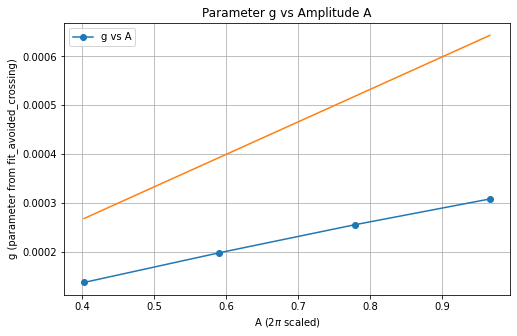

In [8]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def gbs(A,omega):
    #snail parameters
    #snail parameters
    EJ = 70*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

    #cavity1 parameters
    omega_c1 = 3*2*np.pi
    g_int1 = 0.15*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters
    omega_c2 = 7*2*np.pi
    g_int2 = 0.15*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    print(g_int2*snail.c2**0.25)
    eta = A/2/(-omega+np.sqrt(8*EJ*EC*snail.c2))/2/snail.phi_zpf
    print(eta)
    return eta,eta*6*snail.g3*g_int1*snail.c2**0.25/(snail.omegas - omega_c1)*g_int2*snail.c2**0.25/(-snail.omegas +omega_c2)/2/np.pi
# Parameters
B = 4.012 * 2 * np.pi

# A range of values scaled by 2*pi
A_values =np.linspace(0.5,1.2,4) * 2*np.pi

# List to store results
results = []
eta = []
# Loop through A values and compute the gbs function
for A in A_values:
    result = gbs(A, B)
    results.append(result[1])
    eta.append(result[0])

plt.figure(figsize=(8, 5))
plt.plot(eta, g_values, 'o-', label='g vs A')
plt.plot(eta, results)
plt.xlabel('A ($2\pi$ scaled)')
plt.ylabel('g (parameter from fit_avoided_crossing)')
plt.title('Parameter g vs Amplitude A')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
g_values

[0.0001370203472681181,
 0.00019780272373558252,
 0.0002551064845289951,
 0.00030796544311299275]

In [10]:
results

[0.0002679363841557482,
 0.00039297336342843054,
 0.0005180103427011131,
 0.0006430473219737956]

In [11]:
eta

[0.4024539495973205,
 0.5902657927427366,
 0.7780776358881529,
 0.9658894790335693]